# load

> Module for loading result from other software

In [ ]:
#| default_exp cli/load

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import py_gamma as pg

In [ ]:
#| export
import glob
from pathlib import Path
import tempfile
import re
import os
import toml
import zarr

import numpy as np
import pandas as pd
from scipy.constants import speed_of_light
import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster

from decorrelation.cli.utils.logging import get_logger, log_args

from fastcore.script import call_parse

In [ ]:
#| export
def _rdc_width_nlines(image_par):
    """get slc width and number of lines.
    """
    with open(image_par) as f:
        for line in f:
            if re.search('range_samples',line):
                rdc_width = int(line.split()[1])
            if re.search('azimuth_lines',line):
                rdc_nlines = int(line.split()[1])
    return rdc_width, rdc_nlines

In [ ]:
#| export
def _geo_width_nlines(dem_par):
    """get dem width and number of lines.
    """
    with open(dem_par) as f:
        for line in f:
            if re.search('width',line):
                geo_width = int(line.split()[1])
            if re.search('nlines',line):
                geo_nlines = int(line.split()[1])
    return geo_width, geo_nlines

In [ ]:
#| export
def _cor_pos_dem(dem_par):
    """get corner lat and lon and post lat and lon
    """
    with open(dem_par) as f:
        for line in f:
            if re.search('corner_lat',line):
                cor_lat = float(line.split()[1])
            if re.search('corner_lon',line):
                cor_lon = float(line.split()[1])
            if re.search('post_lat',line):
                pos_lat = float(line.split()[1])
            if re.search('post_lon',line):
                pos_lon = float(line.split()[1])
    return cor_lat, cor_lon, pos_lat, pos_lon

In [ ]:
#| export
def _fetch_slc_par_date(rslc_dir,# str / Path
                       ):
    rslc_dir = Path(rslc_dir)
    rslcs = []
    rslc_pars = []
    dates = []
    for rslc in sorted(rslc_dir.glob('*.rslc')):
        rslc_par = rslc.parent / (rslc.name + '.par')
        assert rslc_par.exists(), f'{str(rslc_par)} not exists!'
        date = rslc.stem

        rslcs.append(rslc)
        rslc_pars.append(rslc_par)
        dates.append(date)
    rslcs_df = pd.DataFrame({'date':dates,'rslc':rslcs,'par':rslc_pars})
    return rslcs_df

In [ ]:
#| hide
#| export
def read_gamma_image(imag:str, # gamma raster data
                     width:int, # data width
                     dtype:str='float', # data format, only 'float' and 'fcomplex' are supported
                    ):
    '''read gamma image into numpy array.'''
    if dtype == 'float':
        dt = '>f4'
    elif dtype == 'fcomplex':
        dt = '>c8'
    elif dtype == 'int':
        dt = '>i4'
    elif dtype =='double':
        dt = '>f8'
    else: raise ValueError('Unsupported data type')

    datf = open(imag,"r")
    datf.seek(0,os.SEEK_END)
    size = datf.tell()
    nlines = int(size / int(dt[-1]) / width)
    data = np.fromfile(imag,dtype=dt,count=width*nlines)
    return data.reshape(-1,width)

In [ ]:
#| hide
#| export
def write_gamma_image(imag,path):
    imag = imag.astype(imag.dtype.newbyteorder('big'))
    imag.tofile(path)

In [ ]:
#| hide
#| export
def read_gamma_plist(plist:str,dtype='int'):
    return read_gamma_image(plist,width=2,dtype=dtype)

In [ ]:
#| hide
#| export
def write_gamma_plist(imag,path):
    return write_gamma_image(imag,path)

In [ ]:
#| hide
np.testing.assert_array_equal(read_gamma_image('../../data/gamma/rslc/20210802.rslc',1834,dtype='fcomplex'),
                              pg.read_image('../../data/gamma/rslc/20210802.rslc',width= 1834, dtype= 'fcomplex'))

image:
  width: 1834  number of lines: 2500
data read from image:
  column offset (x0): 0  row offset (y0): 0  
  width: 1834  number of lines: 2500


In [ ]:
#| export
@call_parse
@log_args
def de_load_gamma_flatten_rslc(rslc_dir:str, # gamma rslc directory, the name of the rslc and their par files should be '????????.rslc' and '????????.rslc.par'
                               reference:str, # reference date, eg: '20200202'
                               hgt:str, # the DEM in radar coordinate
                               rslc_zarr:str, # output, the flattened rslcs stack in zarr format
                               az_chunk_size:int=-1, # rslcs stack azimuth chunk size, azimuth number of lines by default (one chunk)
                               log:str=None, # logfile, no log by default
                              ):
    '''Generate flatten rslc data from gamma command and convert them into zarr format.
    The shape of hgt should be same as one rslc image, i.e. the hgt file is generated with 1 by 1 look geocoding.
    '''
    logger = get_logger(logfile=log)
    rslcs = _fetch_slc_par_date(rslc_dir)
    with pd.option_context('display.max_colwidth', 0):
        logger.info('rslc found: \n'+str(rslcs))
    rslc_pars = rslcs['par'].to_list()
    dates = rslcs['date'].to_list()
    rslcs = rslcs['rslc'].to_list()

    reference_idx = dates.index(reference)
    ref_rslc = rslcs[reference_idx]
    ref_rslc_par = rslc_pars[reference_idx]
    hgt = Path(hgt)

    n_image = len(rslcs)
    width,nlines = _rdc_width_nlines(ref_rslc_par)
    logger.info(f'number of images: {n_image}.')
    logger.info(f'image number of lines: {nlines}.')
    logger.info(f'image width: {width}.')

    logger.info('run gamma command to generate required data for flattened rslcs:')
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        sim_orbs = []
        for i,(date,rslc,rslc_par) in enumerate(zip(dates,rslcs,rslc_pars)):
            off_par = temp_dir/(reference+'_'+date+'.off')
            create_offset_command = f'create_offset {str(ref_rslc_par)} {str(rslc_par)} {str(off_par)} 1 1 1 0 > {str(temp_dir/"log")}'
            logger.info('run command: ' + create_offset_command)
            os.system(create_offset_command)
            # pg.create_offset(ref_rslc_par,rslc_par,off_par,1,1,1,0)
            sim_orb = temp_dir/(reference+'_'+date+'.sim_orb')
            phase_sim_orb_command = f'phase_sim_orb {str(ref_rslc_par)} {str(rslc_par)} {str(off_par)} {str(hgt)} {str(sim_orb)} {str(ref_rslc_par)} - - 1 1 > {str(temp_dir/"log")}'
            logger.info('run command: ' + phase_sim_orb_command)
            os.system(phase_sim_orb_command)
            # pg.phase_sim_orb(ref_rslc_par,rslc_par,off_par,hgt,sim_orb,ref_rslc_par,'-','-',1,1)
            sim_orbs.append(sim_orb)
        logger.info('gamma command finished.')
        logger.info('using dask to load data in gamma binary format to calculate flatten rslcs and save it to zarr.')
        logger.info('starting dask local cluster.')
        cluster = LocalCluster()
        client = Client(cluster)
        logger.info('dask local cluster started.')

        read_gamma_image_delayed = delayed(read_gamma_image, pure=True)
        lazy_rslcs = [read_gamma_image_delayed(rslc,width,dtype='fcomplex') for rslc in rslcs]
        lazy_sim_orbs = [read_gamma_image_delayed(sim_orb,width,dtype='float') for sim_orb in sim_orbs]
        rslcs_data = [da.from_delayed(lazy_rslc,dtype= np.complex64,shape=(nlines,width)) for lazy_rslc in lazy_rslcs]
        rslcs_data = da.stack(rslcs_data,axis=2)
        sim_orb_data =[da.from_delayed(lazy_sim_orb,dtype=np.float32,shape=(nlines,width)) for lazy_sim_orb in lazy_sim_orbs]
        sim_orb_data = da.stack(sim_orb_data,axis=2)
        flatten_rslcs_data = da.exp(sim_orb_data*np.complex64(1j))*rslcs_data
        flatten_rslcs_data = flatten_rslcs_data.rechunk((az_chunk_size,width,1))
        logger.info(f'flattened rslcs shape: {flatten_rslcs_data.shape}')
        logger.info(f'flattened rslcs chunks: {flatten_rslcs_data.chunks}')
        _flatten_rslcs_data = flatten_rslcs_data.to_zarr(rslc_zarr,overwrite=True,compute=False)
        logger.info('computing graph setted. doing all the computing.')
        da.compute(_flatten_rslcs_data)
        logger.info('computing finished.')
        cluster.close()
        logger.info('dask cluster closed.')

The method behind the flattened RSLC:

Let the value of i-th rslc be $s_i$, the simulated phase due to DEM and position difference be $u_{ij}$.
D-InSAR basically is:
$$d_{ij}=s_i \times s_j^* \times e^{-ju_{ij}}.$$
Let the distance between satellite and ground target for th i-th observation be $l_i$.
Then, the simulated phase for DInSAR
$$u_{ij} = l_i-l_j.$$
So, a simple conclusion is $$u_{ij}-u_{ik}=-u_{jk}.$$
If we define $$s_i^{\prime} = s_i \times e^{ju_{xi}},$$
where $X$ can be any arbitrary interger less than $N$- the total number of the RSLCs.
Then we can find that
$$int_{ij}^{\prime} =  s_i^{\prime} \times s_j^{\prime*} = s_i \times s_j^* \times e^{j(u_{xi}-u_{xj})} = s_i \times s_j^* \times e^{j(u_{xi}-u_{xj})} = s_i \times s_j^* \times e^{-ju_{ij}} = d_{ij}.$$

We call $s_i^{\prime}$ as flattened RSLC.
The advantage of flattened RSLC is DInSAR can be easily calculated by simple conjugate multiplication.

An example:

In [ ]:
rslc_dir = '../../data/gamma/rslc'
reference = '20220620'
hgt = '../../data/gamma/geocoding/20210802.hgt'
rslc_zarr = './raw/rslc.zarr'
az_chunk_size = 1000

In [ ]:
de_load_gamma_flatten_rslc(rslc_dir,reference,hgt,rslc_zarr,az_chunk_size)

2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - fetching args:
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - rslc_dir = '../../data/gamma/rslc'
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - reference = '20220620'
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - hgt = '../../data/gamma/geocoding/20210802.hgt'
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - rslc_zarr = './raw/rslc.zarr'
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - az_chunk_size = 1000
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - log = None
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - fetching args done.
2023-09-20 19:47:37 - de_load_gamma_flatten_rslc - INFO - rslc found: 
        date                                 rslc  \
0   20210802  ../../data/gamma/rslc/20210802.rslc   
1   20210816  ../../data/gamma/rslc/20210816.rslc   
2   20210830  ../../data/gamma/rslc/20210830.rslc   
3   20210913  ../../data/gamma/rslc/20210913.rslc 

In [ ]:
!de_load_gamma_flatten_rslc -h

usage: de_load_gamma_flatten_rslc [-h] [--az_chunk_size AZ_CHUNK_SIZE]
                                  [--log LOG]
                                  rslc_dir reference hgt rslc_zarr

Generate flatten rslc data from gamma command and convert them into zarr format.
The shape of hgt should be same as one rslc image, i.e. the hgt file is
generated with 1 by 1 look geocoding.

positional arguments:
  rslc_dir                       gamma rslc directory, the name of the rslc and
                                 their par files should be '????????.rslc' and
                                 '????????.rslc.par'
  reference                      reference date, eg: '20200202'
  hgt                            the DEM in radar coordinate
  rslc_zarr                      output, the flattened rslcs stack in zarr
                                 format

options:
  -h, --help                     show this help message and exit
  --az_chunk_size AZ_CHUNK_SIZE  rslcs stack azimuth chunk size, azimuth n

In [ ]:
#| export
@call_parse
@log_args
def de_load_gamma_lat_lon_hgt(diff_par:str, # geocoding diff_par,using the simulated image as reference
                              rslc_par:str, # par file of the reference rslc
                              dem_par:str, # dem par
                              hgt:str, # DEM in radar coordinate
                              lat_zarr:str, # output, latitude zarr
                              lon_zarr:str, # output, longitude zarr
                              hgt_zarr:str, # output, height zarr
                              az_chunk_size:int=-1, # azimuth chunk size of lat and lon zarr, azimuth number of lines by default (one chunk)
                              log:str=None, # logfile, no log by default
):
    '''
    Function to load longitude and latitude from gamma binary format to zarr.
    '''
    logger = get_logger(logfile=log)
    geo_width = _geo_width_nlines(dem_par)[0]
    rdc_width, rdc_nlines = _rdc_width_nlines(rslc_par)
    logger.info(f'image shape: ({rdc_nlines},{rdc_width})')

    lat_data = zarr.open(lat_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = (az_chunk_size,rdc_width), dtype=np.float64)
    lon_data = zarr.open(lon_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = (az_chunk_size,rdc_width), dtype=np.float64)
    hgt_data = zarr.open(hgt_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = (az_chunk_size,rdc_width), dtype=np.float32)

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        logger.info('run gamma command to generate longitude, latitude and height:')
        pt_i = np.arange(rdc_width,dtype=np.int32)
        pt_j = np.arange(rdc_nlines,dtype=np.int32)
        pt_ii,pt_jj = np.meshgrid(pt_i,pt_j)
        pt_ij = np.stack((pt_ii,pt_jj),axis=-1)
        write_gamma_plist(pt_ij,temp_dir/'plist')
        
        # no need to write phgt since it is identical to hgt if all point are selected.
        # hgt_data = read_gamma_image(hgt,width=rdc_width,dtype='float')
        # hgt_data = hgt_data.reshape(-1)
        # pg.write_point_data(hgt_data,temp_dir/'plist',temp_dir/'phgt')
        
        command = f"pt2geo {str(temp_dir/'plist')} - {rslc_par} - {hgt} {dem_par} {diff_par} 1 1 - - {str(temp_dir/'plat_lon')} {str(temp_dir/'phgt_wgs84')} > {str(temp_dir/'log')}"
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')
        ptlonlat = read_gamma_plist(str(temp_dir/'plat_lon'),dtype='double')
        lon_data[:], lat_data[:] = ptlonlat[:,0].reshape(rdc_nlines,rdc_width),ptlonlat[:,1].reshape(rdc_nlines,rdc_width)
        hgt_data[:] = read_gamma_image(str(temp_dir/'phgt_wgs84'),width=rdc_width,dtype='float')
        logger.info('Done.')

In [ ]:
diff_par = '../../data/gamma/geocoding/20210802.diff_par'
rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
dem_par = '../../data/gamma/DEM/dem_seg_par'
hgt = '../../data/gamma/geocoding/20210802.hgt'
lat_zarr = './raw/lat.zarr'
lon_zarr = './raw/lon.zarr'
hgt_zarr = './raw/hgt.zarr'
az_chunk_size = 1000

An example:

In [ ]:
de_load_gamma_lat_lon_hgt(diff_par,rslc_par,dem_par,hgt,lat_zarr,lon_zarr,hgt_zarr,az_chunk_size)

2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - fetching args:
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - diff_par = '../../data/gamma/geocoding/20210802.diff_par'
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - dem_par = '../../data/gamma/DEM/dem_seg_par'
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - hgt = '../../data/gamma/geocoding/20210802.hgt'
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - lat_zarr = './raw/lat.zarr'
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - lon_zarr = './raw/lon.zarr'
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - hgt_zarr = './raw/hgt.zarr'
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - az_chunk_size = 1000
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - log = None
2023-09-20 19:48:12 - de_load_gamma_lat_lon_hgt - INFO - fetching args done.
2023-09-20 19:48:1

In [ ]:
lon_data = zarr.open(lon_zarr,mode='r')[:]
lat_data = zarr.open(lat_zarr,mode='r')[:]
hgt_data = zarr.open(hgt_zarr,mode='r')[:]

lon_data[lon_data==0] = np.nan
lat_data[lat_data==0] = np.nan
hgt_data[hgt_data==0] = np.nan

In [ ]:
from matplotlib import pyplot as plt

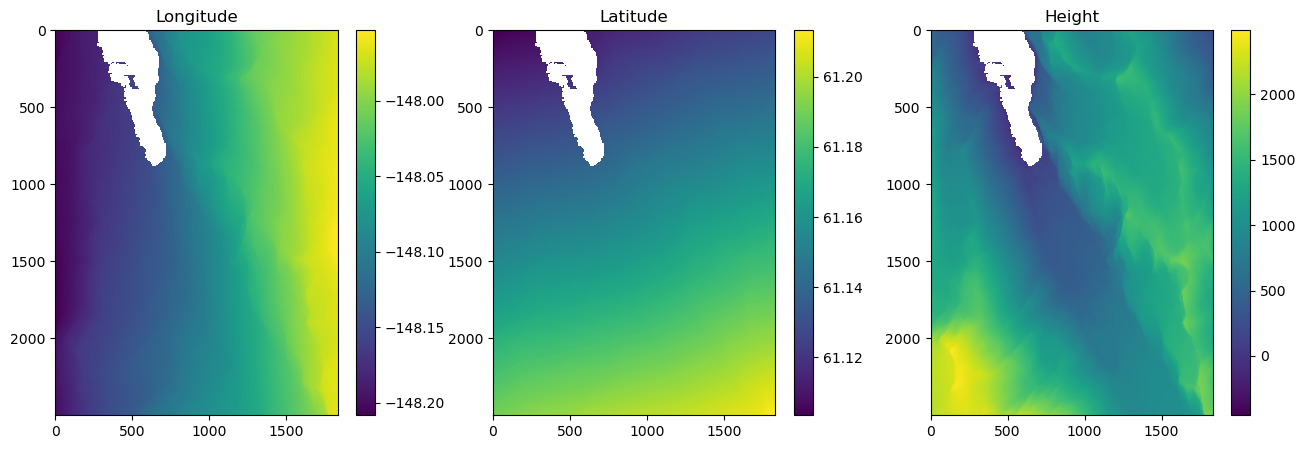

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(16,5))
im0 = axes[0].imshow(lon_data)
axes[0].set_title('Longitude')
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(lat_data)
axes[1].set_title('Latitude')
fig.colorbar(im1, ax=axes[1])
im2 = axes[2].imshow(hgt_data)
axes[2].set_title('Height')
fig.colorbar(im2, ax=axes[2])
fig.show()

In [ ]:
!de_load_gamma_lat_lon_hgt -h

usage: de_load_gamma_lat_lon_hgt [-h] [--az_chunk_size AZ_CHUNK_SIZE]
                                 [--log LOG]
                                 diff_par rslc_par dem_par hgt lat_zarr lon_zarr
                                 hgt_zarr

Function to load longitude and latitude from gamma binary format to zarr.

positional arguments:
  diff_par                       geocoding diff_par,using the simulated image as
                                 reference
  rslc_par                       par file of the reference rslc
  dem_par                        dem par
  hgt                            DEM in radar coordinate
  lat_zarr                       output, latitude zarr
  lon_zarr                       output, longitude zarr
  hgt_zarr                       output, height zarr

options:
  -h, --help                     show this help message and exit
  --az_chunk_size AZ_CHUNK_SIZE  azimuth chunk size of lat and lon zarr, azimuth
                                 number of lines by defaul

In [ ]:
#| export
@call_parse
@log_args
def de_load_gamma_incidence_angle(inc:str, # incidence angle
                                  lt:str, # lookup table
                                  rslc_par:str, # par file of the reference rslc
                                  dem_par:str, # dem par
                                  inc_zarr:str, # output, latitude zarr
                                  az_chunk_size:int=-1, # azimuth chunk size of lat and lon zarr, azimuth number of lines by default (one chunk)
                                  log:str=None, # logfile, no log by default
):
    '''
    Load incidence angle from gamma binary format to zarr.
    The input incidence angle should be in EQA coordinate and generated by gc_map2 with inc_flg=1.
    '''
    logger = get_logger(logfile=log)
    geo_width = _geo_width_nlines(dem_par)[0]
    rdc_width, rdc_nlines = _rdc_width_nlines(rslc_par)
    logger.info(f'image shape: ({rdc_nlines},{rdc_width})')

    inc_data = zarr.open(inc_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = (az_chunk_size,rdc_width), dtype=np.float32)

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        inc_rdc = temp_dir/'inc_rdc'
        logger.info('run gamma command to generate inc angle in range doppler coordinate:')
        command = f'geocode {lt} {inc} {geo_width} {str(inc_rdc)} {rdc_width} {rdc_nlines} > {temp_dir/"log"}'
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')
        logger.info('writing data.')
        inc_data[:] = read_gamma_image(inc_rdc,rdc_width,dtype='float')
        logger.info('Done.')

An example:

In [ ]:
lt = '../../data/gamma/geocoding/20210802.lt_fine'
rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
dem_par = '../../data/gamma/DEM/dem_seg_par'
inc = '../../data/gamma/geocoding/20210802.inc_e'
inc_zarr = './raw/inc.zarr'
az_chunk_size = 1000

In [ ]:
de_load_gamma_incidence_angle(inc,lt,rslc_par,dem_par,inc_zarr,az_chunk_size)

2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - fetching args:
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - inc = '../../data/gamma/geocoding/20210802.inc_e'
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - lt = '../../data/gamma/geocoding/20210802.lt_fine'
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - dem_par = '../../data/gamma/DEM/dem_seg_par'
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - inc_zarr = './raw/inc.zarr'
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - az_chunk_size = 1000
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - log = None
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - fetching args done.
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - image shape: (2500,1834)
2023-09-20 19:48:29 - de_load_gamma_incidence_angle - INFO - run gamma 

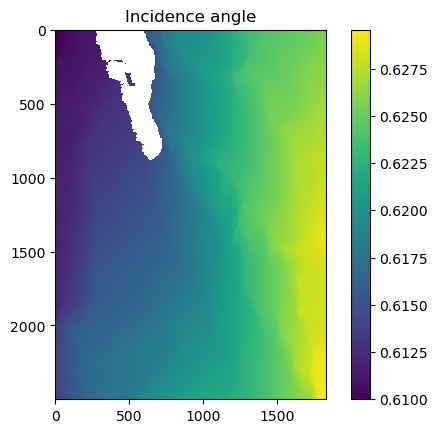

In [ ]:
inc_data = zarr.open(inc_zarr,mode='r')[:]
inc_data[inc_data==0] = np.nan
plt.imshow(inc_data)
plt.colorbar()
plt.title("Incidence angle")
plt.show()

In [ ]:
#| export
@call_parse
@log_args
def de_load_gamma_range(rslc_par:str, # par file of one rslc
                        range_zarr:str, # output, range distance zarr
                        az_chunk_size:int=-1, # azimuth chunk size of lat and lon zarr, azimuth number of lines by default (one chunk)
                        log:str=None, # logfile, no log by default
):
    '''
    Generate slant range distance and save to zarr.
    '''
    logger = get_logger(logfile=log)
    rdc_width, rdc_nlines = _rdc_width_nlines(rslc_par)
    logger.info(f'image shape: ({rdc_nlines},{rdc_width})')
    with open(rslc_par) as f:
        for line in f:
            if re.search('near_range_slc',line):
                rho0 = float(line.split()[1])
            if re.search('range_pixel_spacing',line):
                d_rho = float(line.split()[1])

    logger.info('Calculating slant range distance.')
    rho1d = np.arange(rdc_width)*d_rho+rho0
    rho2d = np.tile(rho1d,(rdc_nlines,1))
    range_data = zarr.open(range_zarr,mode='w',shape=(rdc_nlines,rdc_width),chunks = (az_chunk_size,rdc_width), dtype=np.float32)
    logger.info('writing data.')
    range_data[:] = rho2d
    logger.info('Done.')

An example:

In [ ]:
rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
range_zarr = './raw/range.zarr'
az_chunk_size = 1000

In [ ]:
de_load_gamma_range(rslc_par,range_zarr,az_chunk_size)

2023-09-20 19:48:31 - de_load_gamma_range - INFO - fetching args:
2023-09-20 19:48:31 - de_load_gamma_range - INFO - rslc_par = '../../data/gamma/rslc/20220620.rslc.par'
2023-09-20 19:48:31 - de_load_gamma_range - INFO - range_zarr = './raw/range.zarr'
2023-09-20 19:48:31 - de_load_gamma_range - INFO - az_chunk_size = 1000
2023-09-20 19:48:31 - de_load_gamma_range - INFO - log = None
2023-09-20 19:48:31 - de_load_gamma_range - INFO - fetching args done.
2023-09-20 19:48:31 - de_load_gamma_range - INFO - image shape: (2500,1834)
2023-09-20 19:48:31 - de_load_gamma_range - INFO - Calculating slant range distance.
2023-09-20 19:48:31 - de_load_gamma_range - INFO - writing data.
2023-09-20 19:48:31 - de_load_gamma_range - INFO - Done.


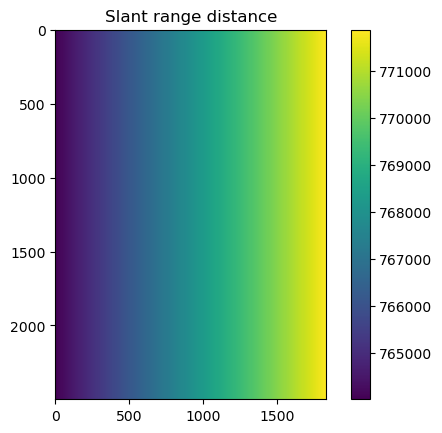

In [ ]:
range_data = zarr.open(range_zarr,mode='r')[:]
range_data[range_data==0] = np.nan
plt.imshow(range_data)
plt.colorbar()
plt.title("Slant range distance")
plt.show()

In [ ]:
#| export
@call_parse
@log_args
def de_load_gamma_metadata(rslc_dir:str, # # gamma rslc directory, the name of the rslc and their par files should be '????????.rslc' and '????????.rslc.par'
                           reference:str, # reference date, eg: '20200202'
                           meta_file:str, # text toml file for meta data
                           log:str=None, # logfile, no log by default
):
    '''
    Load necessary metadata into a toml file.
    '''
    meta = dict()
    rslc_dir = Path(rslc_dir)
    dates = []
    logger = get_logger(logfile=log)
    for par_file in sorted(rslc_dir.glob('*.rslc.par')):
        dates.append(par_file.name[:8])
    meta['dates'] = dates

    with open(rslc_dir/(reference+'.rslc.par')) as f:
        for line in f:
            if re.search('radar_frequency',line):
                radar_f = float(line.split()[1])
                rdr_wavelen = speed_of_light/radar_f
                logger.info('Fetching randar wavelength')
            if re.search('heading',line):
                heading = float(line.split()[1])
                logger.info('Fetching heading angle')
            if re.search('range_pixel_spacing',line):
                dr = float(line.split()[1])
                logger.info('Fetching range pixel spacing')
            if re.search('azimuth_pixel_spacing',line):
                daz = float(line.split()[1])
                logger.info('fetching azimuth pixel spacing')

    meta['radar_wavelength'] = rdr_wavelen
    meta['heading'] = heading
    meta['range_pixel_spacing'] = dr
    meta['azimuth_pixel_spacing'] = daz

    with tempfile.TemporaryDirectory() as temp_dir:        
        temp_dir = Path(temp_dir)
        slc_tab = temp_dir/'slc_tab'
        bperp = temp_dir/'bperp'
        itab = temp_dir/'itab'
        
        tab_content = ''
        for date in dates:
            tab_content += str(rslc_dir/(date+'.rslc'))
            tab_content += '      '
            tab_content += str(rslc_dir/(date+'.rslc.par'))
            tab_content += '\n'
        slc_tab.write_text(tab_content)

        logger.info('Run gamma command to calculate baseline:')
        command = f"base_calc {str(slc_tab)} {str(rslc_dir/(reference+'.rslc.par'))} {str(bperp)} {str(itab)} - > {temp_dir/'log'}"
        logger.info('run command: ' + command)
        os.system(command)
        logger.info('gamma command finished.')
        dat = pd.read_csv(bperp, sep='\s+', header=None)
        base=dat[3].to_numpy()
        base=base.astype(np.float32)

    meta['perpendicular_baseline'] = base

    with open(meta_file,'w') as f:
        a = toml.dump(meta,f,encoder=toml.TomlNumpyEncoder())
    logger.info('All meta data: \n'+a)
    logger.info('writing data in toml file.')
    logger.info('Done.')

An example:

In [ ]:
rslc_dir = '../../data/gamma//rslc'
reference = '20220620'
meta_file = './raw/meta.toml'

In [ ]:
de_load_gamma_metadata(rslc_dir,reference,meta_file)

2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - fetching args:
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - rslc_dir = '../../data/gamma//rslc'
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - reference = '20220620'
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - meta_file = './raw/meta.toml'
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - log = None
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - fetching args done.
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - Fetching heading angle
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - Fetching range pixel spacing
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - fetching azimuth pixel spacing
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - Fetching randar wavelength
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - Run gamma command to calculate baseline:
2023-09-20 19:48:31 - de_load_gamma_metadata - INFO - run command: base_calc /tmp/tmpowhirhou/slc_tab ../../data/gamma/r

In [ ]:
with open(meta_file,'r') as f:
    meta_read = toml.load(f)

In [ ]:
meta_read

{'dates': ['20210802',
  '20210816',
  '20210830',
  '20210913',
  '20211011',
  '20211025',
  '20220606',
  '20220620',
  '20220704',
  '20220718',
  '20220801',
  '20220815',
  '20220829',
  '20220912',
  '20220926',
  '20221010',
  '20221024'],
 'radar_wavelength': 0.24245249210715603,
 'heading': -17.8792397,
 'range_pixel_spacing': 4.29054,
 'azimuth_pixel_spacing': 3.740105,
 'perpendicular_baseline': [-97.61360168457031,
  -45.58580017089844,
  17.86680030822754,
  -26.258899688720703,
  -63.72420120239258,
  -56.363399505615234,
  64.75759887695312,
  0.0,
  -9.043999671936035,
  -13.02869987487793,
  -112.94960021972656,
  -86.09490203857422,
  -129.9635009765625,
  -127.6594009399414,
  -182.29519653320312,
  -129.735107421875,
  -184.31100463867188]}

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()